In [1]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import numpy as np
import pandas as pd
import pylab 
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap
%matplotlib inline
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
from graphviz import Source
from IPython.display import Image

from scipy.stats import skew, norm, probplot, boxcox, f_oneway
from scipy import interp
from sklearn.base import BaseEstimator, TransformerMixin, clone, ClassifierMixin
from sklearn import metrics, tree
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler, PolynomialFeatures, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score

from sklearn.linear_model import LogisticRegression
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.tree import DecisionTreeClassifier
#import xgboost as xgb
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
#from mlxtend.classifier import StackingClassifier

from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

In [2]:
wines_noise = pd.read_csv('../../NumericData/10_noisy_winequality.csv')

wines_noise['quality_label'] = wines_noise.quality.apply(lambda q: 'low' if q <= 5 else 'medium' if q <= 7 else 'high')
#wines.quality_label = pd.Categorical(wines.quality_label, categories=['low', 'medium', 'high'], ordered=True)

# re-shuffle records just to randomize data points
wines_noise = wines_noise.sample(frac=1, random_state=101).reset_index(drop=True)

In [3]:
wines_original = pd.read_csv('../../NumericData/winequality.csv')

wines_original['quality_label'] = wines_original.quality.apply(lambda q: 'low' if q <= 5 else 'medium' if q <= 7 else 'high')
#wines.quality_label = pd.Categorical(wines.quality_label, categories=['low', 'medium', 'high'], ordered=True)

# re-shuffle records just to randomize data points
wines_original = wines_original.sample(frac=1, random_state=101).reset_index(drop=True)

In [4]:
def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

In [5]:
details = rstr(wines_noise, 'quality')
details.sort_values(by='missing_ration', ascending=False)

Data shape: (6497, 14)
___________________________
Data types:
 float64    11
object      2
int64       1
Name: types, dtype: int64
___________________________


types  counts  distincts  nulls  missing_ration  \
fixed acidity         float64    6487        552     10        0.153917   
pH                    float64    6488        131      9        0.138525   
volatile acidity      float64    6489        235      8        0.123134   
sulphates             float64    6493        177      4        0.061567   
citric acid           float64    6495        168      2        0.030783   
chlorides             float64    6495        246      2        0.030783   
residual sugar        float64    6496        869      1        0.015392   
type                   object    6497          2      0        0.000000   
free sulfur dioxide   float64    6497        744      0        0.000000   
total sulfur dioxide  float64    6497        887      0        0.000000   
density               float64    6497        972      0        0.000000   
alcohol               float64    6497        464      0        0.000000   
quality                 int64    6497          7      0        0.000000   
quality_label          object    6497          3      0        0.000000   

                                                                uniques  \
fixed acidity         [[7.3, 6.9, 9.5, 8.2, 7.9, 9.8, 7.0, 7.2, 6.5,...   
pH                    [[3.28, 3.51, 3.12, 3.09, 3.27, 3.07, 3.05, 3....   
volatile acidity      [[0.28, 1.09, 0.46, 0.27, 0.34, 0.13, 0.25, 0....   
sulphates             [[0.82, 0.43, 0.74, 0.68, 0.51, 0.55, 0.38, 0....   
citric acid           [[0.42, 0.06, 0.24, 0.4, 0.41, 0.39, 0.37, 0.2...   
chlorides             [[0.04, 0.061, 0.092, 0.057999999999999996, 0....   
residual sugar        [[14.4, 2.1, 2.7, 2.2, 4.9, 1.4, 12.85, 2.0, 1...   
type                                                     [[white, red]]   
free sulfur dioxide   [[49.0, 12.0, 14.0, 6.0, 31.0, 3.0, 36.0, 55.0...   
total sulfur dioxide  [[173.0, 31.0, 426.18, 10.0, 153.0, 7.0, 105.0...   
density               [[0.9994, 0.9948, 0.998, 1.03, 0.9966, 0.9947,...   
alcohol               [[9.0, 11.4, 10.0, 11.2, 9.7, 10.7, 9.5, 10.4,...   
quality                                         [[7, 4, 6, 5, 8, 3, 9]]   
quality_label                                     [[medium, low, high]]   

                      skewness   kurtosis  corr quality  
fixed acidity         1.980931   4.820309     -0.047880  
pH                    0.777363   1.496362      0.004471  
volatile acidity      2.153168   5.366624     -0.164756  
sulphates             2.734779   8.959053      0.016651  
citric acid           2.408023   7.961973      0.036182  
chlorides             3.507362  12.405193     -0.073969  
residual sugar        3.039251  10.083541     -0.017249  
type                       NaN        NaN           NaN  
free sulfur dioxide   3.233249  11.382833      0.031482  
total sulfur dioxide  1.052301   2.485929     -0.033577  
density               3.405843  13.485832     -0.112187  
alcohol               0.681468  -0.107291      0.378985  
quality               0.189623   0.232322      1.000000  
quality_label              NaN        NaN           NaN

In [6]:
wines_noise.quality_label.value_counts()


medium    3915
low       2384
high       198
Name: quality_label, dtype: int64

In [7]:
wines_noise.dropna().quality_label.value_counts()


medium    3896
low       2372
high       197
Name: quality_label, dtype: int64

In [8]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """
        Impute missing values:
        - Columns of dtype object are imputed with the most frequent value in column.
        - Columns of other types are imputed with mean of column.
        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

wines_noise = DataFrameImputer().fit_transform(wines_noise)
wines_noise.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.3              0.28         0.42            14.4   
1    red            6.9              1.09         0.06             2.1   
2    red            9.5              0.46         0.24             2.7   
3    red            8.2              0.27         0.40             2.2   
4  white            7.9              0.28         0.41             4.9   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.040                 49.0                173.00   0.9994  3.28   
1      0.061                 12.0                 31.00   0.9948  3.51   
2      0.092                 14.0                426.18   0.9980  3.12   
3      0.058                  6.0                 10.00   1.0300  3.09   
4      0.058                 31.0                153.00   0.9966  3.27   

   sulphates  alcohol  quality quality_label  
0       0.82      9.0        7        medium  
1       0.43     11.4        4           low  
2       0.74     10.0        6        medium  
3       0.68     11.2        7        medium  
4       0.51      9.7        6        medium

In [9]:
wines_original.quality_label.value_counts()


medium    3915
low       2384
high       198
Name: quality_label, dtype: int64

In [10]:
wines_original.dropna().quality_label.value_counts()


medium    3894
low       2372
high       197
Name: quality_label, dtype: int64

In [11]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """
        Impute missing values:
        - Columns of dtype object are imputed with the most frequent value in column.
        - Columns of other types are imputed with mean of column.
        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

wines_original = DataFrameImputer().fit_transform(wines_original)
wines_original.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.3              0.28         0.42            14.4   
1    red            6.9              1.09         0.06             2.1   
2    red            9.5              0.46         0.24             2.7   
3    red            8.2              0.31         0.40             2.2   
4  white            7.9              0.28         0.41             4.9   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.040                 49.0                 173.0  0.99940  3.28   
1      0.061                 12.0                  31.0  0.99480  3.51   
2      0.092                 14.0                  44.0  0.99800  3.12   
3      0.058                  6.0                  10.0  0.99536  3.31   
4      0.058                 31.0                 153.0  0.99660  3.27   

   sulphates  alcohol  quality quality_label  
0       0.82      9.0        7        medium  
1       0.43     11.4        4           low  
2       0.74     10.0        6        medium  
3       0.68     11.2        7        medium  
4       0.51      9.7        6        medium

In [12]:
#Descriptive Statistics_ByType
subset_attributes = wines_noise.columns
rs = round(wines_noise.loc[wines_noise.type == 'red', subset_attributes].describe(),2)
ws = round(wines_noise.loc[wines_noise.type == 'white', subset_attributes].describe(),2)
pd.concat([rs, ws], axis=0, keys=['Red Wine Statistics', 'White Wine Statistics']).T

Red Wine Statistics                                    \
                                   count   mean    std   min    25%    50%   
fixed acidity                     1776.0   8.29   1.99  3.84   7.00   7.80   
volatile acidity                  1776.0   0.53   0.25  0.08   0.35   0.50   
citric acid                       1776.0   0.33   0.29  0.00   0.12   0.29   
residual sugar                    1776.0   6.13  11.08  0.80   1.90   2.30   
chlorides                         1776.0   0.10   0.09  0.01   0.06   0.08   
free sulfur dioxide               1776.0  30.04  46.81  1.00   9.00  17.00   
total sulfur dioxide              1776.0  74.12  73.58  6.00  25.00  48.00   
density                           1776.0   1.00   0.01  0.99   1.00   1.00   
pH                                1776.0   3.30   0.20  2.72   3.18   3.30   
sulphates                         1776.0   0.68   0.28  0.23   0.53   0.61   
alcohol                           1776.0  10.55   1.26  8.04   9.50  10.30   
quality                           1776.0   5.66   0.82  3.00   5.00   6.00   

                                    White Wine Statistics                 \
                        75%     max                 count    mean    std   
fixed acidity          9.20   15.90                4721.0    7.17   1.63   
volatile acidity       0.64    1.58                4721.0    0.33   0.23   
citric acid            0.45    1.66                4721.0    0.38   0.24   
residual sugar         3.70   65.73                4721.0    8.84  10.87   
chlorides              0.09    0.61                4721.0    0.07   0.10   
free sulfur dioxide   29.00  288.38                4721.0   45.87  44.50   
total sulfur dioxide  99.00  437.44                4721.0  144.61  61.58   
density                1.00    1.04                4721.0    1.00   0.01   
pH                     3.40    4.01                4721.0    3.21   0.19   
sulphates              0.75    2.00                4721.0    0.55   0.26   
alcohol               11.30   14.90                4721.0   10.60   1.33   
quality                6.00    8.00                4721.0    5.88   0.89   

                                                            
                       min     25%     50%     75%     max  
fixed acidity         3.80    6.30    6.80    7.50   15.85  
volatile acidity      0.08    0.22    0.27    0.35    1.58  
citric acid           0.00    0.27    0.32    0.41    1.65  
residual sugar        0.60    1.80    6.00   11.30   65.57  
chlorides             0.01    0.04    0.04    0.05    0.61  
free sulfur dioxide   1.75   24.00   35.00   50.00  288.50  
total sulfur dioxide  6.00  107.00  136.00  173.00  440.00  
density               0.99    0.99    0.99    1.00    1.04  
pH                    2.72    3.08    3.18    3.30    4.01  
sulphates             0.22    0.41    0.49    0.58    2.00  
alcohol               8.00    9.50   10.40   11.50   14.90  
quality               3.00    5.00    6.00    6.00    9.00

In [13]:
#Descriptive Statistics_ByQuality
#subset_attributes = ['alcohol', 'volatile acidity', 'pH', 'quality']
ls = round(wines_noise[wines_noise['quality_label'] == 'low'][subset_attributes].describe(),2)
ms = round(wines_noise[wines_noise['quality_label'] == 'medium'][subset_attributes].describe(),2)
hs = round(wines_noise[wines_noise['quality_label'] == 'high'][subset_attributes].describe(),2)
pd.concat([ls, ms, hs], axis=0, keys=['Low Quality Wine', 'Medium Quality Wine', 'High Quality Wine']).T

Low Quality Wine                                      \
                                count    mean    std   min    25%     50%   
fixed acidity                  2384.0    7.57   1.77  3.84   6.50    7.20   
volatile acidity               2384.0    0.44   0.25  0.09   0.27    0.35   
citric acid                    2384.0    0.36   0.27  0.00   0.21    0.31   
residual sugar                 2384.0    8.52  11.34  0.60   1.90    4.30   
chlorides                      2384.0    0.09   0.10  0.01   0.04    0.05   
free sulfur dioxide            2384.0   40.09  45.17  1.75  15.00   28.00   
total sulfur dioxide           2384.0  128.75  76.19  6.00  72.00  128.00   
density                        2384.0    1.00   0.01  0.99   0.99    1.00   
pH                             2384.0    3.23   0.20  2.72   3.10    3.20   
sulphates                      2384.0    0.58   0.27  0.22   0.44    0.51   
alcohol                        2384.0   10.02   1.08  8.00   9.30    9.70   
quality                        2384.0    4.88   0.36  3.00   5.00    5.00   

                                     Medium Quality Wine           ...    \
                         75%     max               count    mean   ...     
fixed acidity           8.00   15.90              3915.0    7.44   ...     
volatile acidity        0.56    1.58              3915.0    0.36   ...     
citric acid             0.44    1.66              3915.0    0.37   ...     
residual sugar         10.92   65.57              3915.0    7.84   ...     
chlorides               0.08    0.61              3915.0    0.08   ...     
free sulfur dioxide    48.00  288.50              3915.0   41.97   ...     
total sulfur dioxide  174.00  440.00              3915.0  123.41   ...     
density                 1.00    1.04              3915.0    1.00   ...     
pH                      3.34    4.00              3915.0    3.23   ...     
sulphates               0.61    2.00              3915.0    0.59   ...     
alcohol                10.50   14.90              3915.0   10.87   ...     
quality                 5.00    5.00              3915.0    6.28   ...     

                                     High Quality Wine                        \
                         75%     max             count    mean    std    min   
fixed acidity           7.80   15.88             198.0    7.18   1.76   4.40   
volatile acidity        0.40    1.58             198.0    0.34   0.22   0.10   
citric acid             0.41    1.65             198.0    0.37   0.23   0.03   
residual sugar          9.60   65.73             198.0    8.09   9.84   0.80   
chlorides               0.07    0.61             198.0    0.06   0.08   0.01   
free sulfur dioxide    45.00  287.94             198.0   50.56  53.37   3.00   
total sulfur dioxide  157.00  438.92             198.0  122.57  59.87  12.00   
density                 1.00    1.04             198.0    0.99   0.01   0.99   
pH                      3.34    4.01             198.0    3.24   0.19   2.79   
sulphates               0.64    2.00             198.0    0.57   0.29   0.25   
alcohol                11.80   14.90             198.0   11.72   1.42   8.14   
quality                 7.00    7.00             198.0    8.03   0.16   8.00   

                                                     
                        25%     50%     75%     max  
fixed acidity          6.30    6.90    7.46   14.70  
volatile acidity       0.21    0.28    0.37    1.43  
citric acid            0.28    0.32    0.38    1.64  
residual sugar         2.10    4.70   10.05   58.59  
chlorides              0.03    0.04    0.05    0.53  
free sulfur dioxide   27.00   37.00   49.00  276.76  
total sulfur dioxide  95.25  118.50  148.00  437.49  
density                0.99    0.99    1.00    1.04  
pH                     3.13    3.24    3.35    3.98  
sulphates              0.39    0.49    0.64    1.96  
alcohol               11.00   12.05   12.63   14.85  
quality                8.00    8.00    8.00    9.00  


In [15]:
# re-shuffle records just to randomize data points
wines_noise = wines_noise.sample(frac=1, random_state=101).reset_index(drop=True)

class_tp = LabelEncoder()
y_tp = class_tp.fit_transform(wines_noise.type.values) # 1 - White; 0 - Red
wines_noise['color'] = y_tp

class_ql = {'low':0, 'medium': 1, 'high': 2}
y_ql = wines_noise.quality_label.map(class_ql)

In [16]:
# re-shuffle records just to randomize data points
wines_original = wines_original.sample(frac=1, random_state=101).reset_index(drop=True)

class_tp = LabelEncoder()
y_tp = class_tp.fit_transform(wines_original.type.values) # 1 - White; 0 - Red
wines_original['color'] = y_tp

class_ql = {'low':0, 'medium': 1, 'high': 2}
y_ql = wines_original.quality_label.map(class_ql)

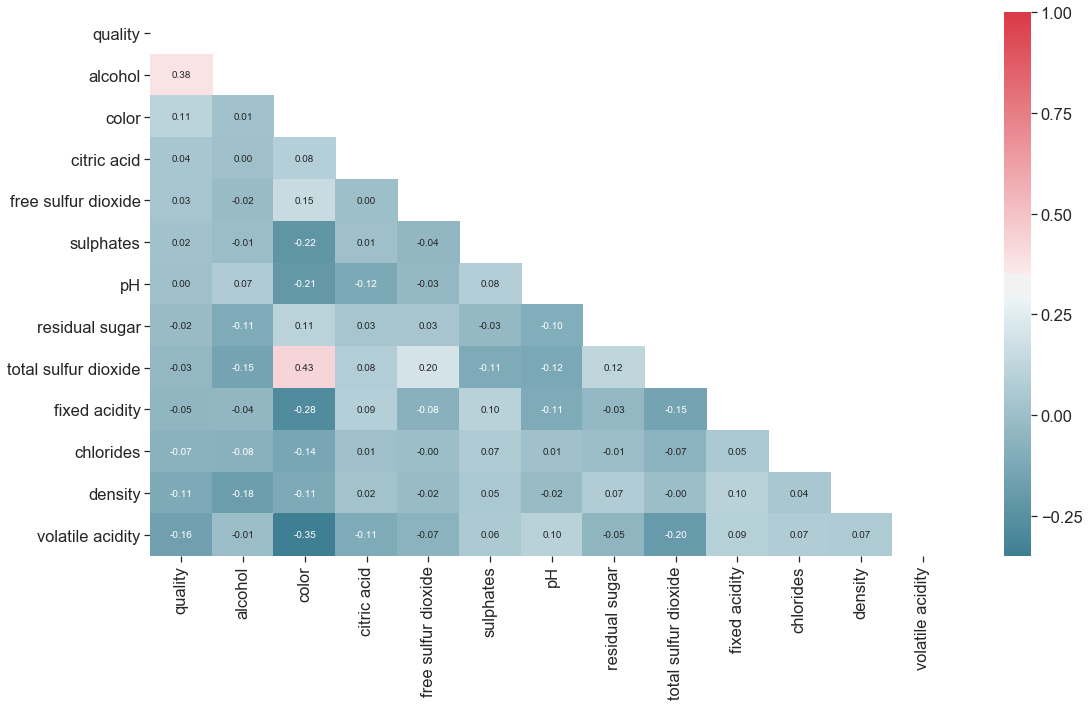

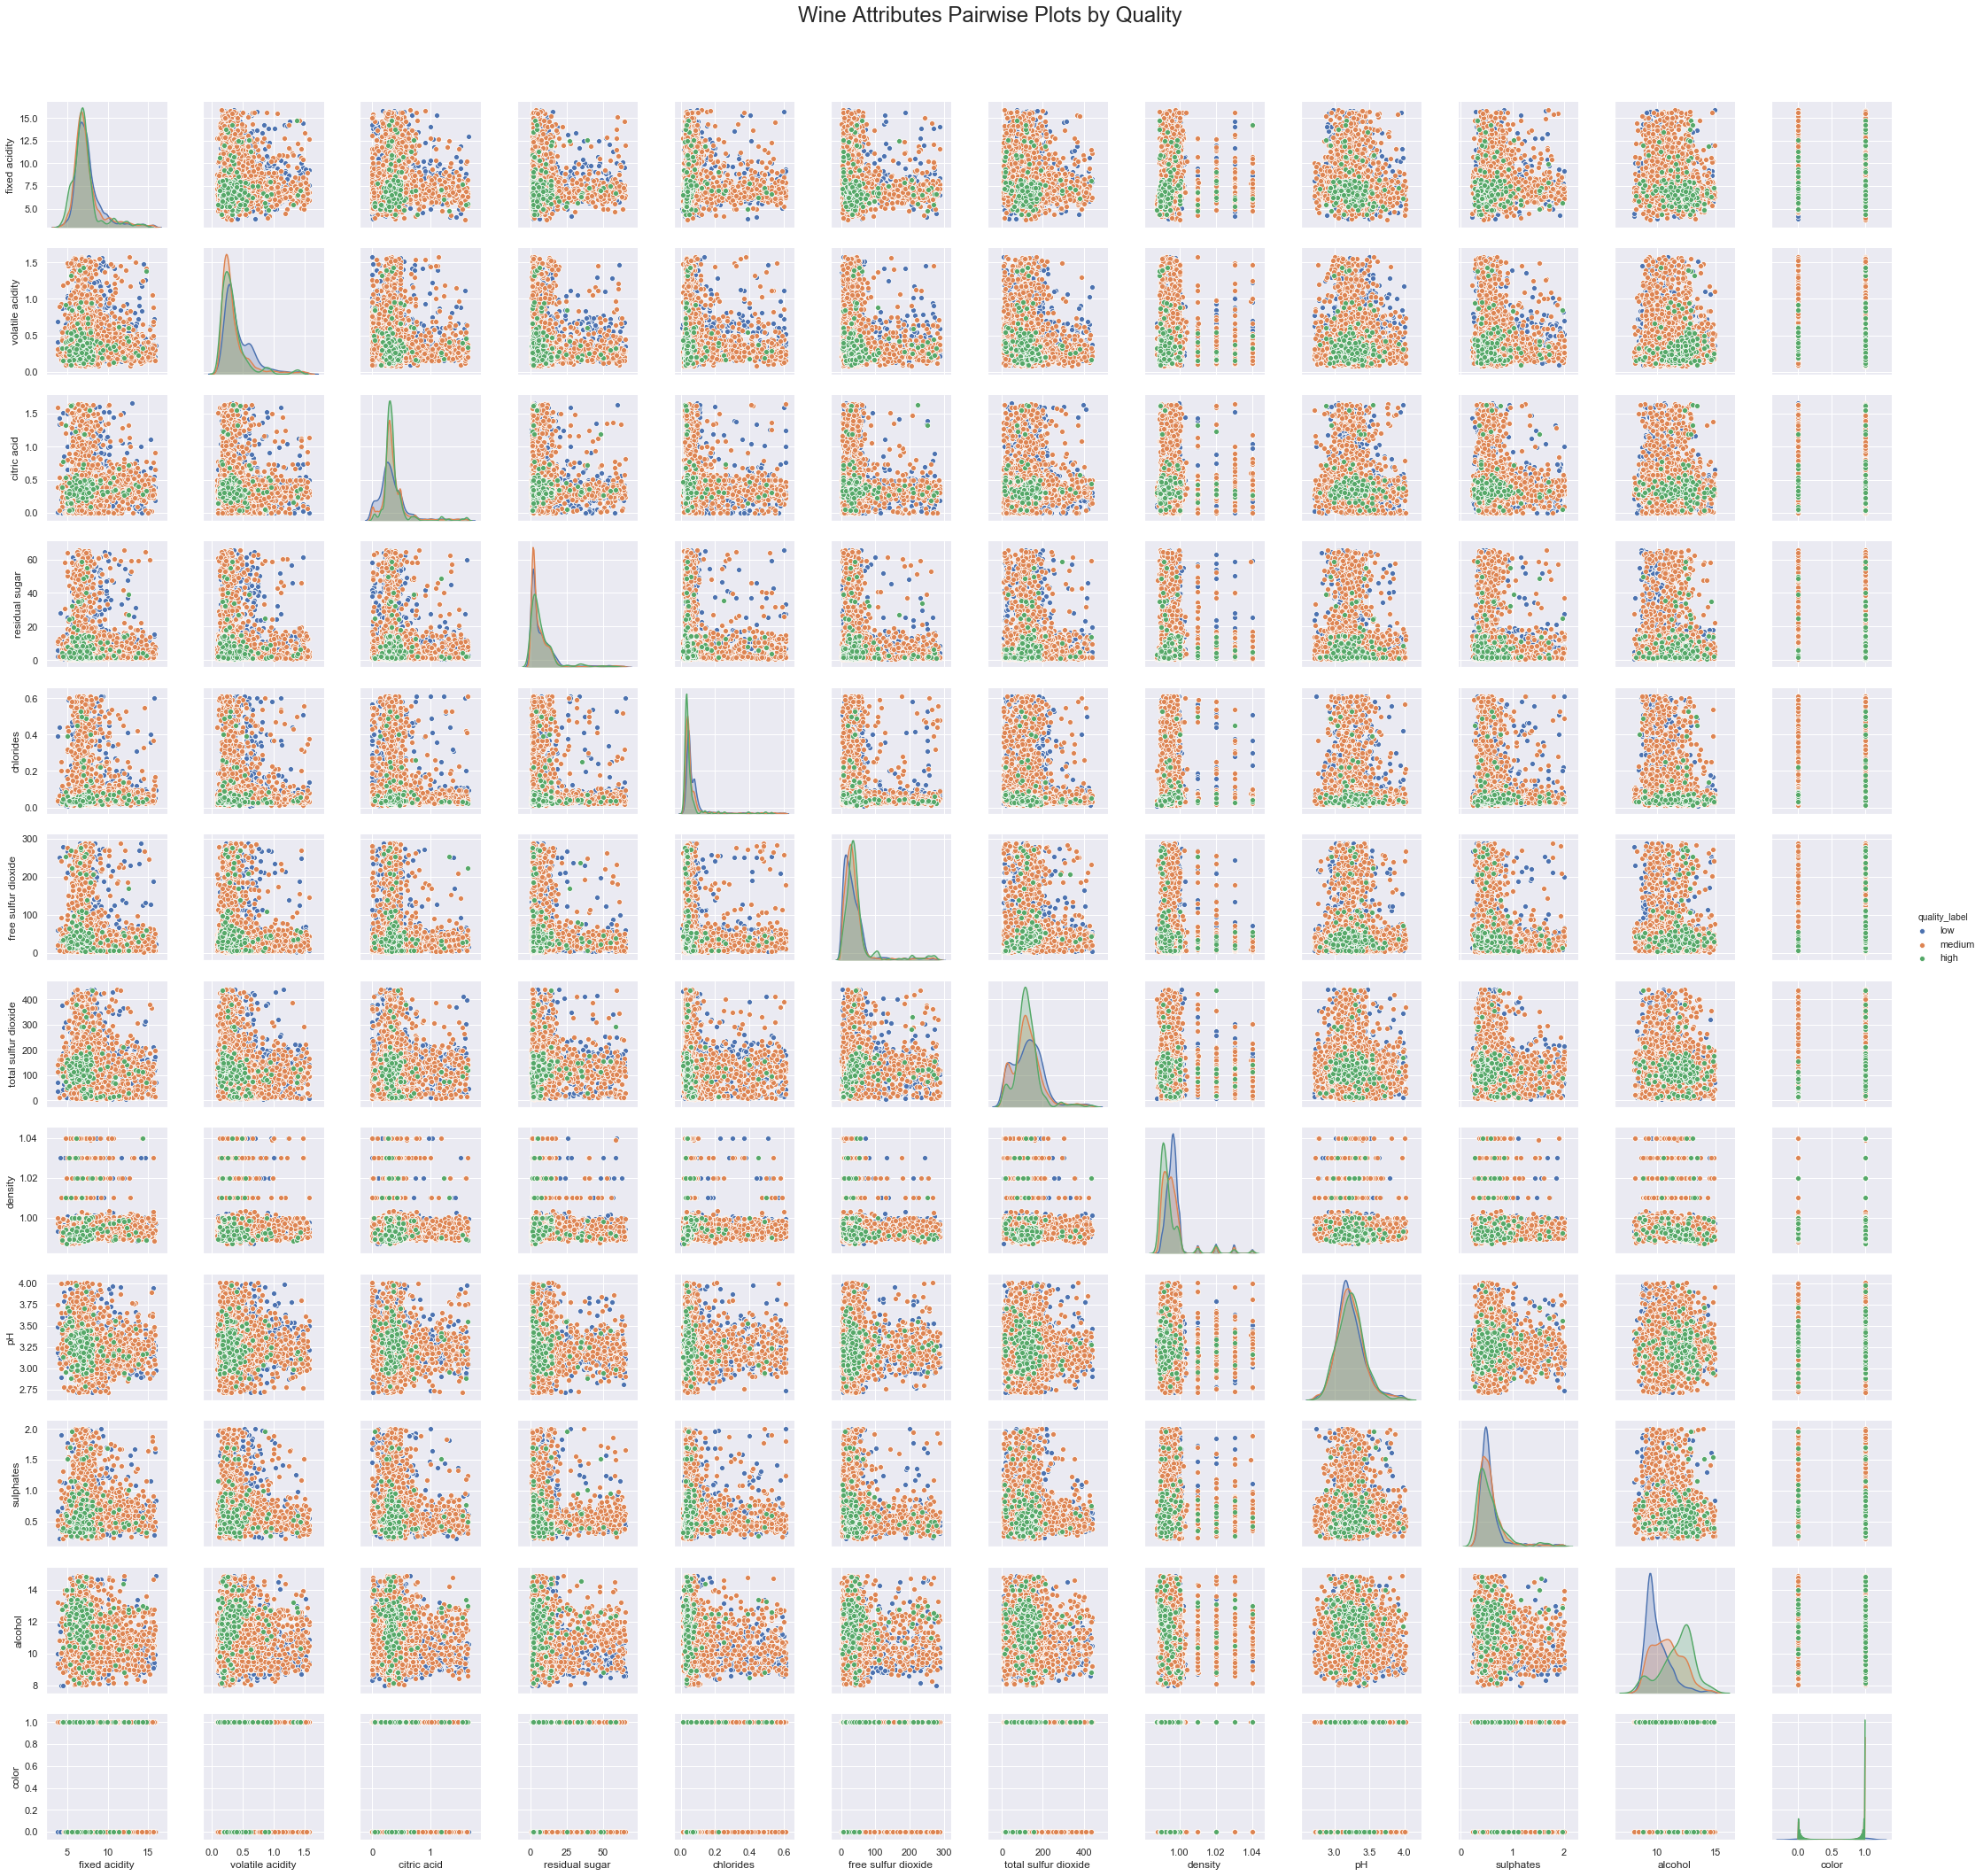

In [17]:
corr = wines_noise.corr()
top_corr_cols = corr.quality.sort_values(ascending=False).keys() 
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
plt.figure(figsize=(18, 10))
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=1.5)

sns.set(font_scale=1.0)
cols = wines_noise.columns
cols = cols.drop('quality')
g = sns.pairplot(data = wines_noise.loc[:, cols], hue='quality_label')
fig = g.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Wine Attributes Pairwise Plots by Quality', fontsize=24)

plt.show()

del corr, dropSelf, top_corr, g, fig, t


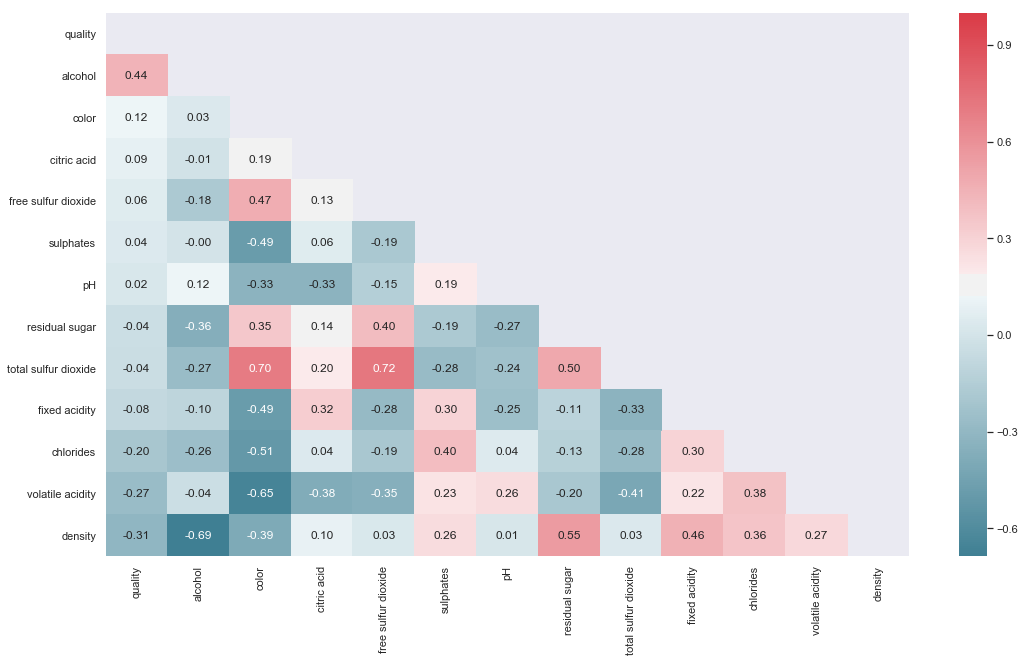

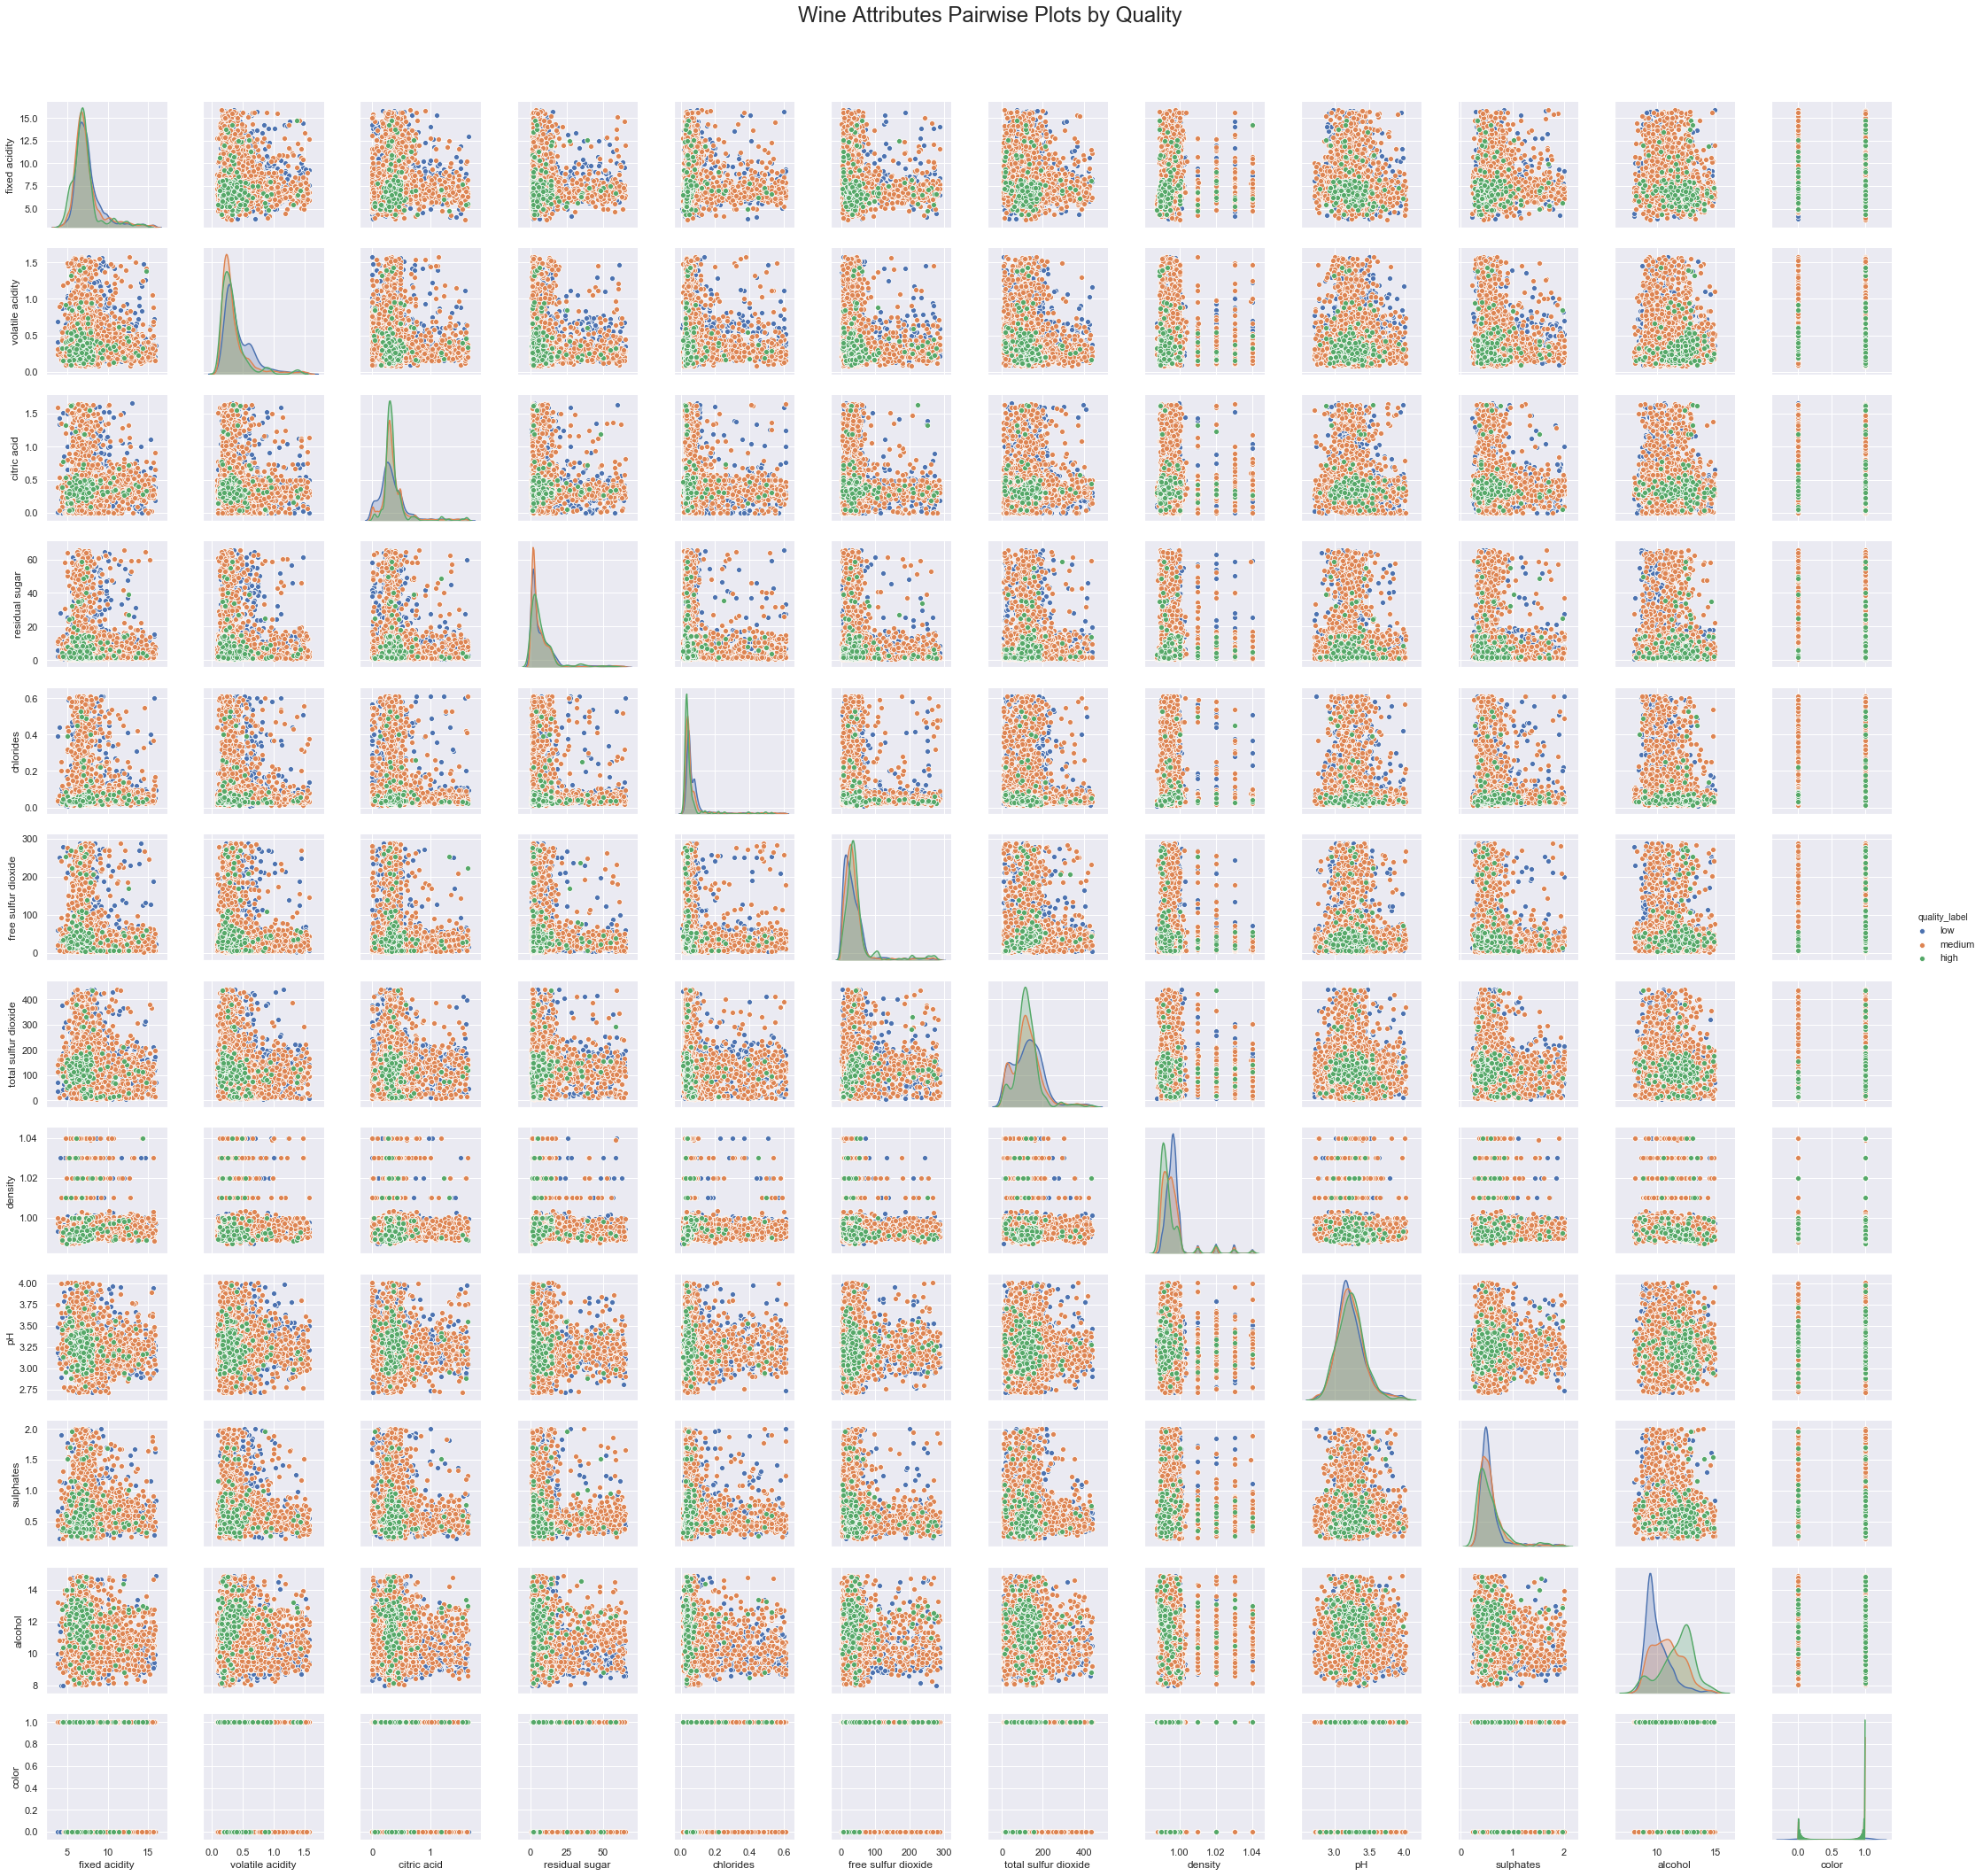

In [18]:
corr = wines_original.corr()
top_corr_cols = corr.quality.sort_values(ascending=False).keys() 
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
plt.figure(figsize=(18, 10))
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=1.5)

sns.set(font_scale=1.0)
cols = wines_original.columns
cols = cols.drop('quality')
g = sns.pairplot(data = wines_noise.loc[:, cols], hue='quality_label')
fig = g.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Wine Attributes Pairwise Plots by Quality', fontsize=24)

plt.show()

del corr, dropSelf, top_corr, g, fig, t


In [19]:
numeric_features = list(wines_noise.dtypes[(wines_noise.dtypes != "str") & (wines_noise.dtypes !='object')].index)
numeric_features.remove('color')

skewed_features = wines_noise[numeric_features].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness = pd.DataFrame({'Skew' :skewed_features})   

# Get only higest skewed features
skewness = skewness[abs(skewness) > 0.7]
skewness = skewness.dropna()
print ("There are {} higest skewed numerical features to box cox transform".format(skewness.shape[0]))

l_opt = {}

for feat in skewness.index:
    wines_noise[feat], l_opt[feat] = boxcox((wines_noise[feat]+1))

skewed_features2 = wines_noise[skewness.index].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness2 = pd.DataFrame({'New Skew' :skewed_features2})   
display(pd.concat([skewness, skewness2], axis=1).sort_values(by=['Skew'], ascending=False))

There are 10 higest skewed numerical features to box cox transform


Skew  New Skew
chlorides             3.507091  0.697045
density               3.405057  2.425312
free sulfur dioxide   3.232503 -0.006541
residual sugar        3.038783  0.155263
sulphates             2.734989  0.064516
citric acid           2.407837 -0.104222
volatile acidity      2.153997  0.183710
fixed acidity         1.981999 -0.082612
total sulfur dioxide  1.052058 -0.008680
pH                    0.777722 -0.029088

In [20]:
wines_noise.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0    red       0.577770          0.242732     0.087345        1.038793   
1  white       0.572554          0.142075     0.234217        1.763205   
2  white       0.565665          0.248772     0.160511        0.797758   
3  white       0.578085          0.181354     0.287907        1.500592   
4  white       0.565665          0.149051     0.234217        0.692261   

   chlorides  free sulfur dioxide  total sulfur dioxide  density        pH  \
0   0.057123             1.724814             35.807204  0.02159  0.301411   
1   0.027920             3.368694             23.992847  0.02159  0.300866   
2   0.021311             2.614479             16.984437  0.02159  0.301350   
3   0.045382             3.741725             29.024325  0.02159  0.300091   
4   0.050549             3.433625             17.806729  0.02159  0.300866   

   sulphates  alcohol  quality quality_label  color  
0   0.213925     11.2        4           low      0  
1   0.191760      8.8        6        medium      1  
2   0.195060     12.5        6        medium      1  
3   0.203724      9.0        5           low      1  
4   0.239023     12.1        7        medium      1

In [22]:
numeric_features = list(wines_original.dtypes[(wines_original.dtypes != "str") & (wines_original.dtypes !='object')].index)
numeric_features.remove('color')

skewed_features = wines_original[numeric_features].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness = pd.DataFrame({'Skew' :skewed_features})   

# Get only higest skewed features
skewness = skewness[abs(skewness) > 0.7]
skewness = skewness.dropna()
print ("There are {} higest skewed numerical features to box cox transform".format(skewness.shape[0]))

l_opt = {}

for feat in skewness.index:
    wines_noise[feat], l_opt[feat] = boxcox((wines_original[feat]+1))

skewed_features2 = wines_original[skewness.index].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness2 = pd.DataFrame({'New Skew' :skewed_features2})   
display(pd.concat([skewness, skewness2], axis=1).sort_values(by=['Skew'], ascending=False))

There are 6 higest skewed numerical features to box cox transform


Skew  New Skew
chlorides            5.399433  5.399433
sulphates            1.798605  1.798605
fixed acidity        1.723733  1.723733
volatile acidity     1.496087  1.496087
residual sugar       1.434889  1.434889
free sulfur dioxide  1.219784  1.219784

In [23]:
wines_original.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            5.9             0.290         0.16             7.9   
1    red           10.1             0.935         0.22             3.4   
2    red            9.1             0.340         0.42             1.8   
3  white            5.4             0.185         0.19             7.1   
4  white            7.9             0.190         0.26             2.1   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.044                 48.0                 197.0  0.99512  3.21   
1      0.105                 11.0                  86.0  1.00100  3.43   
2      0.058                  9.0                  18.0  0.99392  3.18   
3      0.048                 36.0                 110.0  0.99438  3.26   
4      0.039                  8.0                 143.0  0.99420  3.05   

   sulphates  alcohol  quality quality_label  color  
0       0.36      9.4        5           low      1  
1       0.64     11.3        4           low      0  
2       0.55     11.4        5           low      0  
3       0.41      9.5        6        medium      1  
4       0.74      9.8        5           low      1

In [24]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

def VRF(predict, data, y):
   
    scale = StandardScaler(with_std=False)
    df = pd.DataFrame(scale.fit_transform(data), columns= cols)
    features = "+".join(cols)
    df['quality_label'] = y.values

    # get y and X dataframes based on this regression:
    y, X = dmatrices(predict + ' ~' + features, data = df, return_type='dataframe')

   # Calculate VIF Factors
    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    # Inspect VIF Factors
    display(vif.sort_values('VIF Factor'))
    return vif

cols = wines_noise.columns.str.replace(' ', '_')
df = wines_noise.copy()
df.columns = cols
# Remove the not applied to the qualty classification task
cols = list(cols.drop(['type', 'quality_label', 'quality']))

vif = VRF('quality_label', df.loc[:, cols], y_ql)


VIF Factor              features
0     1.000000             Intercept
8     1.001292               density
11    1.041550               alcohol
3     1.074567           citric_acid
9     1.085681                    pH
4     1.217200        residual_sugar
10    1.220958             sulphates
1     1.238802         fixed_acidity
2     1.361918      volatile_acidity
7     1.429659  total_sulfur_dioxide
12    1.443124                 color
6     1.449764   free_sulfur_dioxide
5     1.517193             chlorides

In [25]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

def VRF(predict, data, y):
   
    scale = StandardScaler(with_std=False)
    df = pd.DataFrame(scale.fit_transform(data), columns= cols)
    features = "+".join(cols)
    df['quality_label'] = y.values

    # get y and X dataframes based on this regression:
    y, X = dmatrices(predict + ' ~' + features, data = df, return_type='dataframe')

   # Calculate VIF Factors
    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    # Inspect VIF Factors
    display(vif.sort_values('VIF Factor'))
    return vif

cols = wines_original.columns.str.replace(' ', '_')
df = wines_original.copy()
df.columns = cols
# Remove the not applied to the qualty classification task
cols = list(cols.drop(['type', 'quality_label', 'quality']))

vif = VRF('quality_label', df.loc[:, cols], y_ql)


VIF Factor              features
0     1.000000             Intercept
10    1.553300             sulphates
3     1.620286           citric_acid
5     1.658053             chlorides
2     2.164411      volatile_acidity
6     2.236447   free_sulfur_dioxide
9     2.544397                    pH
7     4.044881  total_sulfur_dioxide
1     5.008898         fixed_acidity
11    5.586239               alcohol
12    7.219469                 color
4     9.586359        residual_sugar
8    22.207092               density

In [26]:
cols = wines_noise.columns.str.replace(' ', '_')
df = wines_noise.copy()
df.columns = cols
# Remove the higest correlations and run a multiple regression
cols = list(cols.drop(['type', 'quality_label', 'quality', 'residual_sugar', 'total_sulfur_dioxide']))

vif = VRF('quality_label', df.loc[:, cols], y_ql)

del df, vif

VIF Factor             features
0     1.000000            Intercept
6     1.001213              density
9     1.007605              alcohol
3     1.067340          citric_acid
10    1.075683                color
7     1.085371                   pH
8     1.204734            sulphates
5     1.230665  free_sulfur_dioxide
1     1.231102        fixed_acidity
2     1.358386     volatile_acidity
4     1.516973            chlorides

In [27]:
cols = wines_original.columns.str.replace(' ', '_')
df = wines_original.copy()
df.columns = cols
# Remove the higest correlations and run a multiple regression
cols = list(cols.drop(['type', 'quality_label', 'quality', 'residual_sugar', 'total_sulfur_dioxide']))

vif = VRF('quality_label', df.loc[:, cols], y_ql)

del df, vif

VIF Factor             features
0     1.000000            Intercept
5     1.445440  free_sulfur_dioxide
8     1.456303            sulphates
3     1.603759          citric_acid
7     1.611557                   pH
4     1.630363            chlorides
2     2.084068     volatile_acidity
1     2.528013        fixed_acidity
9     2.572116              alcohol
6     3.367309              density
10    3.715577                color

In [28]:
wines_original.head()


type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            5.9             0.290         0.16             7.9   
1    red           10.1             0.935         0.22             3.4   
2    red            9.1             0.340         0.42             1.8   
3  white            5.4             0.185         0.19             7.1   
4  white            7.9             0.190         0.26             2.1   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.044                 48.0                 197.0  0.99512  3.21   
1      0.105                 11.0                  86.0  1.00100  3.43   
2      0.058                  9.0                  18.0  0.99392  3.18   
3      0.048                 36.0                 110.0  0.99438  3.26   
4      0.039                  8.0                 143.0  0.99420  3.05   

   sulphates  alcohol  quality quality_label  color  
0       0.36      9.4        5           low      1  
1       0.64     11.3        4           low      0  
2       0.55     11.4        5           low      0  
3       0.41      9.5        6        medium      1  
4       0.74      9.8        5           low      1

In [29]:
wines_noise.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0    red       0.585237          0.160994     0.087345        1.419711   
1  white       0.599249          0.235665     0.234217        1.097168   
2  white       0.597260          0.173996     0.160511        0.832692   
3  white       0.581843          0.123911     0.287907        1.382007   
4  white       0.594065          0.126056     0.234217        0.896790   

   chlorides  free sulfur dioxide  total sulfur dioxide  density        pH  \
0   0.027194            10.219669             35.807204  0.02104  0.301411   
1   0.038760             4.482891             23.992847  0.02104  0.300866   
2   0.031399             3.965127             16.984437  0.02104  0.301350   
3   0.028537             8.777457             29.024325  0.02104  0.300091   
4   0.025330             3.684154             17.806729  0.02104  0.300866   

   sulphates  alcohol  quality quality_label  color  
0   0.198550     11.2        4           low      0  
1   0.253576      8.8        6        medium      1  
2   0.240189     12.5        6        medium      1  
3   0.211772      9.0        5           low      1  
4   0.265321     12.1        7        medium      1

In [30]:
wqp_class_labels = np.array(wines_noise['quality_label'])
target_names = ['low', 'medium', 'high']

cols = wines_noise.columns
cols = list(cols.drop(['type', 'quality_label', 'quality']))
X_train_noise, X_test_noise, y_train_noise, y_test_noise = train_test_split(wines_noise.loc[:, cols], y_ql.values, test_size=0.20, random_state=101)

In [31]:
X_train_noise.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
547        0.592730          0.121721     0.261276        1.549099   0.029466   
4125       0.581843          0.141720     0.216883        0.757959   0.021371   
497        0.589027          0.205514     0.250152        0.916219   0.033874   
4147       0.585840          0.158086     0.250152        1.632528   0.024102   
3639       0.587520          0.130215     0.221357        0.757959   0.024521   

      free sulfur dioxide  total sulfur dioxide  density        pH  sulphates  \
547              7.038202             22.347347  0.02104  0.301151   0.218828   
4125            12.771075             19.369570  0.02104  0.301456   0.285198   
497              3.684154             20.237607  0.02104  0.300583   0.252235   
4147             8.098480             26.455256  0.02104  0.300804   0.218828   
3639             8.646008             25.452178  0.02104  0.301004   0.231270   

      alcohol  color  
547       9.9      1  
4125     12.2      1  
497      10.1      1  
4147     10.4      1  
3639      9.5      0

In [32]:
wqp_class_labels = np.array(wines_original['quality_label'])
target_names = ['low', 'medium', 'high']

cols = wines_original.columns
cols = list(cols.drop(['type', 'quality_label', 'quality']))
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(wines_original.loc[:, cols], y_ql.values, test_size=0.20, random_state=101)

In [33]:
wines_original.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            5.9             0.290         0.16             7.9   
1    red           10.1             0.935         0.22             3.4   
2    red            9.1             0.340         0.42             1.8   
3  white            5.4             0.185         0.19             7.1   
4  white            7.9             0.190         0.26             2.1   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.044                 48.0                 197.0  0.99512  3.21   
1      0.105                 11.0                  86.0  1.00100  3.43   
2      0.058                  9.0                  18.0  0.99392  3.18   
3      0.048                 36.0                 110.0  0.99438  3.26   
4      0.039                  8.0                 143.0  0.99420  3.05   

   sulphates  alcohol  quality quality_label  color  
0       0.36      9.4        5           low      1  
1       0.64     11.3        4           low      0  
2       0.55     11.4        5           low      0  
3       0.41      9.5        6        medium      1  
4       0.74      9.8        5           low      1

In [58]:
#Modelling with Noisy Training Data and Clean Test data

from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

model.fit(X_train_noise, y_train_noise.ravel())
y_pred = model.predict(X_test_original)

In [59]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
cm = confusion_matrix(y_test_original, y_pred)
print(cm)
print(accuracy_score(y_test_original, y_pred))
print(f1_score(y_test_original, y_pred,average='weighted'))

[[123 367   0]
 [100 663   0]
 [  3  44   0]]
0.604615384615
0.553159642351


In [60]:
# importing Random Forest function
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

model.fit(X_train_noise, y_train_noise.ravel())
y_pred = model.predict(X_test_original)

In [61]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
cm = confusion_matrix(y_test_original, y_pred)
print(cm)
print(accuracy_score(y_test_original, y_pred))
print(f1_score(y_test_original, y_pred,average='weighted'))

[[448  42   0]
 [584 179   0]
 [ 32  15   0]]
0.482307692308
0.427653807654


In [62]:
from sklearn.svm import SVC

classifier = SVC(random_state=0, kernel='rbf',probability=True)
classifier.fit(X_train_noise, y_train_noise.ravel())
y_pred = classifier.predict(X_test_original)

In [63]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
cm = confusion_matrix(y_test_original, y_pred)
print(cm)
print(accuracy_score(y_test_original, y_pred))
print(f1_score(y_test_original, y_pred,average='weighted'))

[[  0 490   0]
 [  0 763   0]
 [  0  47   0]]
0.586923076923
0.43414668705
